# 02A — Macro-to-Sector Relationship Map

**Purpose**: Identify which macro variables affect which sectors (direction & strength only)

**Principle**: This is where understanding begins. No signals, just structural relationships.

**Techniques**:
- Rolling correlations (5Y)
- Heatmaps
- Sign consistency analysis

**Output**: Macro × Sector Sensitivity Map

---

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

PROCESSED_PATH = Path('../data_processed')

# Load combined matrix
combined = pd.read_parquet(PROCESSED_PATH / 'macro_sector_monthly_matrix.parquet')

print(f"Combined matrix: {combined.shape}")
print(f"Date range: {combined.index.min().date()} to {combined.index.max().date()}")

Combined matrix: (132, 93)
Date range: 2015-02-28 to 2026-01-31


## 1. Separate Index Returns and Macro Variables

In [2]:
# Split columns by type
index_cols = [c for c in combined.columns if c.startswith('IDX_')]
macro_cols = [c for c in combined.columns if c.startswith('MACRO_')]
global_cols = [c for c in combined.columns if c.startswith('GLOBAL_')]

print(f"Index columns: {len(index_cols)}")
print(f"Macro columns: {len(macro_cols)}")
print(f"Global columns: {len(global_cols)}")

# Clean column names for display
def clean_name(col):
    return col.replace('IDX_', '').replace('MACRO_', '').replace('GLOBAL_', '')[:20]

# Get data
index_returns = combined[index_cols].dropna(how='all')
macro_vars = combined[macro_cols + global_cols].dropna(how='all')

Index columns: 21
Macro columns: 64
Global columns: 8


## 2. Static Correlation Matrix

In [3]:
# Calculate full-sample correlation
# Drop columns with too much missing data
index_clean = index_returns.dropna(axis=1, thresh=int(len(index_returns) * 0.7))
macro_clean = macro_vars.dropna(axis=1, thresh=int(len(macro_vars) * 0.5))

# Combine for correlation
analysis_df = pd.concat([index_clean, macro_clean], axis=1).dropna()

print(f"Analysis period: {len(analysis_df)} months")
print(f"Index variables: {len(index_clean.columns)}")
print(f"Macro variables: {len(macro_clean.columns)}")

Analysis period: 99 months
Index variables: 21
Macro variables: 72


In [4]:
# Calculate correlation between macro and indices
corr_matrix = pd.DataFrame(
    index=macro_clean.columns,
    columns=index_clean.columns,
    data=np.nan
)

for macro_col in macro_clean.columns:
    for idx_col in index_clean.columns:
        # Get valid pairs
        valid = analysis_df[[macro_col, idx_col]].dropna()
        if len(valid) >= 30:  # Minimum 30 observations
            corr_matrix.loc[macro_col, idx_col] = valid[macro_col].corr(valid[idx_col])

# Sort by average absolute correlation
corr_matrix['avg_abs_corr'] = corr_matrix.drop(columns=['avg_abs_corr'], errors='ignore').abs().mean(axis=1)
corr_matrix = corr_matrix.sort_values('avg_abs_corr', ascending=False).drop(columns=['avg_abs_corr'])

print(f"Correlation matrix shape: {corr_matrix.shape}")

Correlation matrix shape: (72, 21)


## 3. Correlation Heatmap (Top Variables)

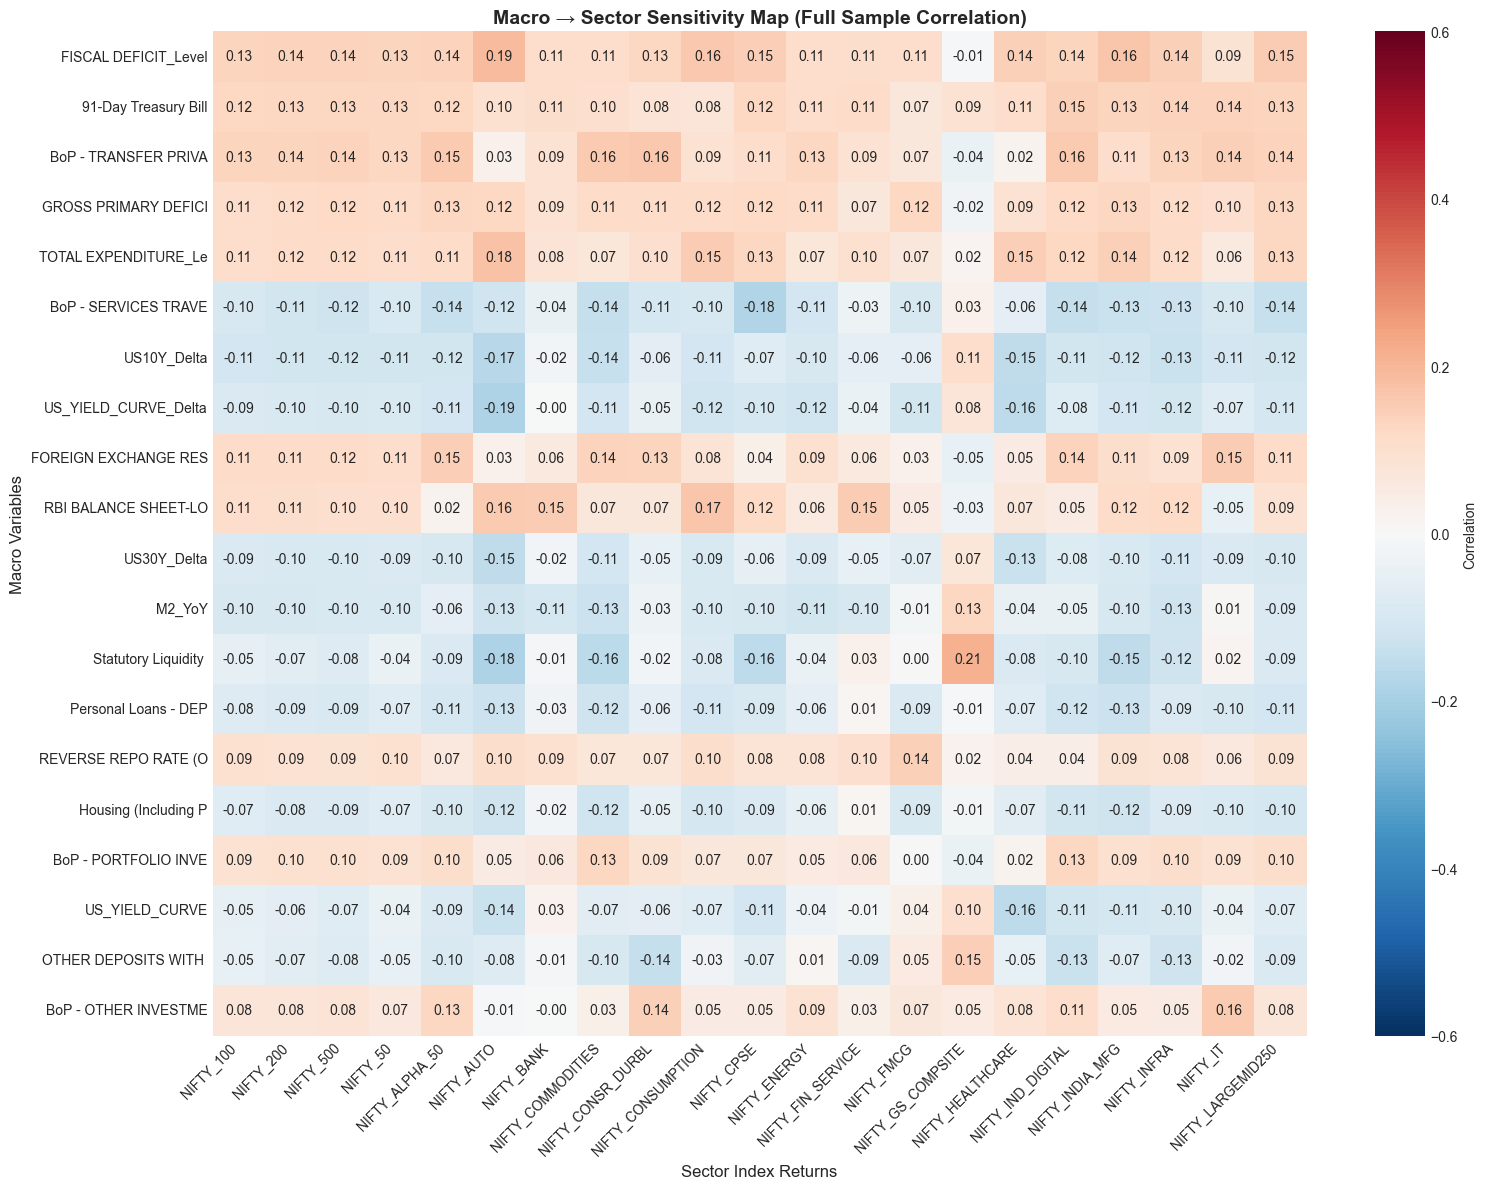

✓ Saved: macro_sector_heatmap.png


In [5]:
# Take top 20 macro variables by average correlation
top_n = min(20, len(corr_matrix))
corr_top = corr_matrix.head(top_n)

# Clean names for display
corr_display = corr_top.copy()
corr_display.index = [clean_name(c) for c in corr_display.index]
corr_display.columns = [clean_name(c) for c in corr_display.columns]

# Plot heatmap
fig, ax = plt.subplots(figsize=(16, 12))
sns.heatmap(
    corr_display.astype(float),
    cmap='RdBu_r',
    center=0,
    vmin=-0.6,
    vmax=0.6,
    annot=True,
    fmt='.2f',
    ax=ax,
    cbar_kws={'label': 'Correlation'}
)
ax.set_title('Macro → Sector Sensitivity Map (Full Sample Correlation)', fontsize=14, fontweight='bold')
ax.set_xlabel('Sector Index Returns', fontsize=12)
ax.set_ylabel('Macro Variables', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(PROCESSED_PATH / 'macro_sector_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved: macro_sector_heatmap.png")

## 4. Rolling Correlation (5-Year Window)

In [6]:
def rolling_correlation(series1: pd.Series, series2: pd.Series, window: int = 60) -> pd.Series:
    """Calculate rolling correlation with N-month window."""
    combined = pd.concat([series1, series2], axis=1).dropna()
    if len(combined) < window:
        return pd.Series(dtype=float)
    
    return combined.iloc[:, 0].rolling(window=window).corr(combined.iloc[:, 1])

# Select key pairs to analyze
KEY_PAIRS = [
    # (macro_col, index_col, description)
    ('GLOBAL_US10Y', 'IDX_NIFTY_BANK', 'US 10Y → Banks'),
    ('GLOBAL_US10Y', 'IDX_NIFTY_IT', 'US 10Y → IT'),
]

# Find pairs that exist in our data
available_pairs = []
for macro, idx, desc in KEY_PAIRS:
    if macro in combined.columns and idx in combined.columns:
        available_pairs.append((macro, idx, desc))

# If no key pairs available, select top correlated pairs
if len(available_pairs) == 0:
    print("Key pairs not found, selecting top correlated pairs...")
    # Find top 4 pairs by correlation
    top_pairs = []
    for macro_col in corr_matrix.head(10).index:
        for idx_col in corr_matrix.columns:
            corr_val = corr_matrix.loc[macro_col, idx_col]
            if pd.notna(corr_val):
                top_pairs.append((macro_col, idx_col, abs(corr_val)))
    
    top_pairs = sorted(top_pairs, key=lambda x: x[2], reverse=True)[:4]
    available_pairs = [(m, i, f"{clean_name(m)} → {clean_name(i)}") for m, i, _ in top_pairs]

print(f"Analyzing {len(available_pairs)} pairs")

Analyzing 2 pairs


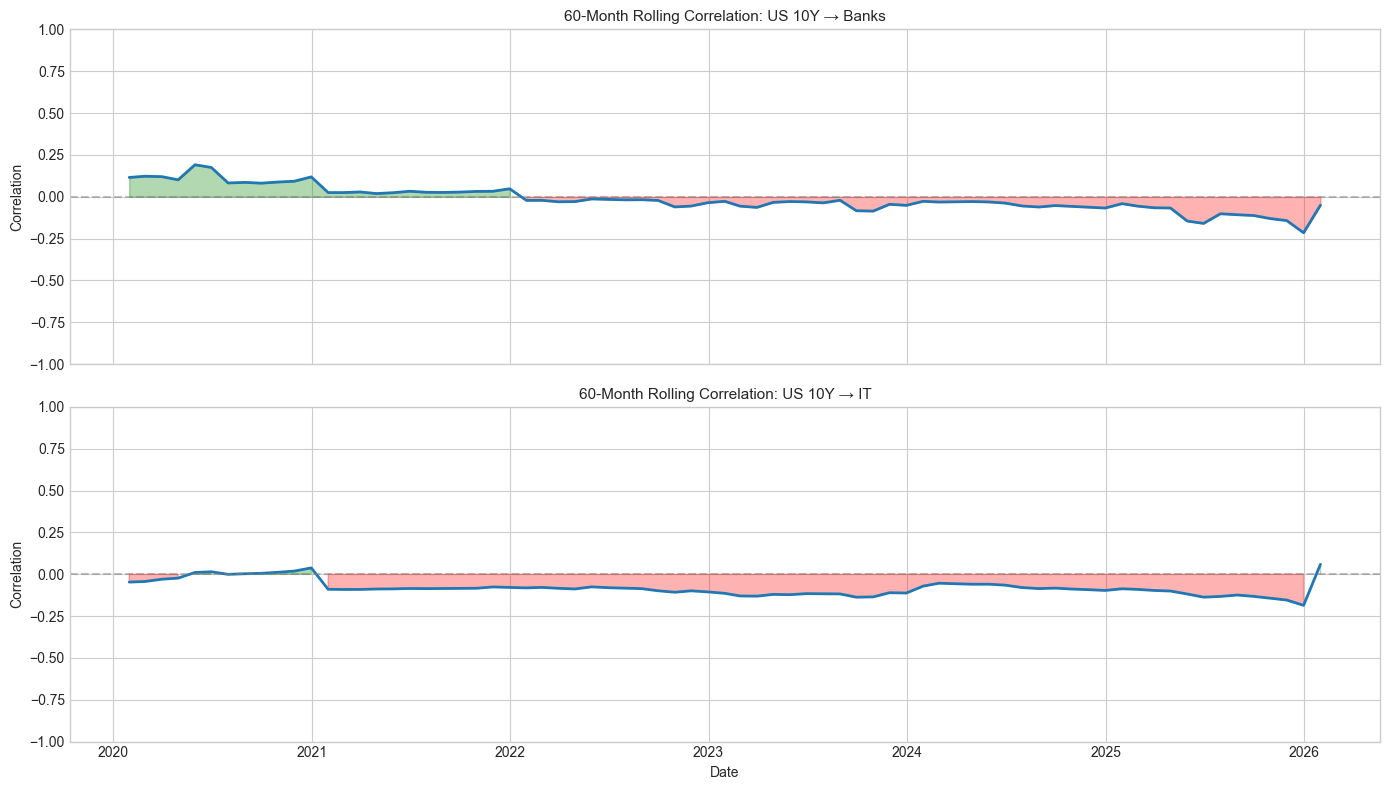

✓ Saved: rolling_correlations.png


In [7]:
# Plot rolling correlations
if len(available_pairs) > 0:
    fig, axes = plt.subplots(len(available_pairs), 1, figsize=(14, 4*len(available_pairs)), sharex=True)
    if len(available_pairs) == 1:
        axes = [axes]
    
    for ax, (macro_col, idx_col, desc) in zip(axes, available_pairs):
        rolling_corr = rolling_correlation(
            combined[macro_col], 
            combined[idx_col], 
            window=60  # 60 months = 5 years
        )
        
        if len(rolling_corr) > 0:
            ax.plot(rolling_corr.index, rolling_corr.values, linewidth=2)
            ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
            ax.fill_between(rolling_corr.index, 0, rolling_corr.values, 
                           where=rolling_corr.values > 0, alpha=0.3, color='green')
            ax.fill_between(rolling_corr.index, 0, rolling_corr.values, 
                           where=rolling_corr.values < 0, alpha=0.3, color='red')
            ax.set_ylabel('Correlation')
            ax.set_title(f'60-Month Rolling Correlation: {desc}', fontsize=11)
            ax.set_ylim(-1, 1)
    
    axes[-1].set_xlabel('Date')
    plt.tight_layout()
    plt.savefig(PROCESSED_PATH / 'rolling_correlations.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("✓ Saved: rolling_correlations.png")
else:
    print("No valid pairs for rolling correlation analysis")

## 5. Sign Consistency Analysis

In [8]:
def sign_consistency(series1: pd.Series, series2: pd.Series, window: int = 60) -> float:
    """
    Calculate what % of time the correlation sign stays stable.
    Higher = more reliable relationship.
    """
    rolling_corr = rolling_correlation(series1, series2, window)
    if len(rolling_corr) < 24:  # Need at least 2 years of rolling data
        return np.nan
    
    # Calculate sign changes
    signs = np.sign(rolling_corr.dropna())
    most_common_sign = signs.mode().iloc[0] if len(signs.mode()) > 0 else 0
    consistency = (signs == most_common_sign).mean()
    
    return consistency * 100

# Calculate sign consistency for all macro-sector pairs
consistency_matrix = pd.DataFrame(
    index=corr_matrix.index,
    columns=corr_matrix.columns,
    data=np.nan
)

print("Calculating sign consistency (this may take a moment)...")
for macro_col in corr_matrix.head(15).index:  # Top 15 macro
    for idx_col in corr_matrix.columns:
        consistency_matrix.loc[macro_col, idx_col] = sign_consistency(
            combined[macro_col], combined[idx_col]
        )

print("✓ Sign consistency calculated")

Calculating sign consistency (this may take a moment)...


✓ Sign consistency calculated


In [9]:
# Find most reliable relationships (high correlation + high consistency)
reliable_relationships = []

for macro_col in corr_matrix.head(15).index:
    for idx_col in corr_matrix.columns:
        corr_val = corr_matrix.loc[macro_col, idx_col]
        consist_val = consistency_matrix.loc[macro_col, idx_col]
        
        if pd.notna(corr_val) and pd.notna(consist_val):
            if abs(corr_val) > 0.2 and consist_val > 70:  # Meaningful and consistent
                reliable_relationships.append({
                    'macro': clean_name(macro_col),
                    'sector': clean_name(idx_col),
                    'correlation': corr_val,
                    'sign_consistency': consist_val,
                    'direction': '↑' if corr_val > 0 else '↓'
                })

reliable_df = pd.DataFrame(reliable_relationships)
if len(reliable_df) > 0:
    reliable_df = reliable_df.sort_values('sign_consistency', ascending=False)
    print(f"Reliable relationships found: {len(reliable_df)}")
    print("\nTop 10 Most Reliable Macro-Sector Relationships:")
    display(reliable_df.head(10))
else:
    print("No highly reliable relationships found with current thresholds")

Reliable relationships found: 1

Top 10 Most Reliable Macro-Sector Relationships:


,macro,sector,correlation,sign_consistency,direction
0,Statutory Liquidity,NIFTY_GS_COMPSITE,0.212182,77.142857,↑


## 6. Sector Sensitivity Summary

In [10]:
# For each sector, identify top macro drivers
sector_drivers = {}

for idx_col in corr_matrix.columns:
    sector_corrs = corr_matrix[idx_col].dropna().sort_values(key=abs, ascending=False)
    top_drivers = sector_corrs.head(5)
    
    sector_drivers[clean_name(idx_col)] = [
        f"{clean_name(macro)}: {corr:.2f}" 
        for macro, corr in top_drivers.items()
    ]

# Display as table
driver_summary = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in sector_drivers.items()]))
driver_summary.index = ['Driver 1', 'Driver 2', 'Driver 3', 'Driver 4', 'Driver 5']

print("Sector Macro Sensitivity Summary:")
print("(Top 5 correlated macro variables per sector)")
driver_summary

Sector Macro Sensitivity Summary:
(Top 5 correlated macro variables per sector)


,NIFTY_100,NIFTY_200,NIFTY_500,NIFTY_50,NIFTY_ALPHA_50,NIFTY_AUTO,NIFTY_BANK,NIFTY_COMMODITIES,NIFTY_CONSR_DURBL,NIFTY_CONSUMPTION,...,NIFTY_ENERGY,NIFTY_FIN_SERVICE,NIFTY_FMCG,NIFTY_GS_COMPSITE,NIFTY_HEALTHCARE,NIFTY_IND_DIGITAL,NIFTY_INDIA_MFG,NIFTY_INFRA,NIFTY_IT,NIFTY_LARGEMID250
Driver 1,FISCAL DEFICIT_Level: 0.13,FISCAL DEFICIT_Level: 0.14,FISCAL DEFICIT_Level: 0.14,FISCAL DEFICIT_Level: 0.13,BoP - TRANSFER PRIVA: 0.15,FISCAL DEFICIT_Level: 0.19,RBI BALANCE SHEET-LO: 0.15,Statutory Liquidity : -0.16,BoP - TRANSFER PRIVA: 0.16,RBI BALANCE SHEET-LO: 0.17,...,BoP - TRANSFER PRIVA: 0.13,RBI BALANCE SHEET-LO: 0.15,REVERSE REPO RATE (O: 0.14,RBI'S REFERENCE RATE: -0.23,BoP - PORTFOLIO FORE: 0.18,BoP - TRANSFER PRIVA: 0.16,FISCAL DEFICIT_Level: 0.16,FISCAL DEFICIT_Level: 0.14,BoP - OTHER INVESTME: 0.16,FISCAL DEFICIT_Level: 0.15
Driver 2,BoP - TRANSFER PRIVA: 0.13,BoP - TRANSFER PRIVA: 0.14,BoP - TRANSFER PRIVA: 0.14,BoP - TRANSFER PRIVA: 0.13,FOREIGN EXCHANGE RES: 0.15,US_YIELD_CURVE_Delta: -0.19,SUM OF CREDIT TO THE: 0.14,BoP - TRANSFER PRIVA: 0.16,BoP - OTHER INVESTME: 0.14,FISCAL DEFICIT_Level: 0.16,...,US_YIELD_CURVE_Delta: -0.12,SUM OF CREDIT TO THE: 0.14,GROSS PRIMARY DEFICI: 0.12,ALL INDIA HOUSE PRIC: 0.23,US_YIELD_CURVE_Delta: -0.16,91-Day Treasury Bill: 0.15,Statutory Liquidity : -0.15,91-Day Treasury Bill: 0.14,BoP - PORTFOLIO FORE: 0.15,BoP - TRANSFER PRIVA: 0.14
Driver 3,91-Day Treasury Bill: 0.12,91-Day Treasury Bill: 0.13,91-Day Treasury Bill: 0.13,91-Day Treasury Bill: 0.13,FISCAL DEFICIT_Level: 0.14,Statutory Liquidity : -0.18,FOREIGN TRADE EXPORT: 0.13,BoP - SERVICES TRAVE: -0.14,OTHER DEPOSITS WITH : -0.14,TOTAL EXPENDITURE_Le: 0.15,...,M2_YoY: -0.11,BoP - TRANSFER OFFIC: 0.14,DEMAND DEPOSITS WITH: 0.12,Statutory Liquidity : 0.21,US_YIELD_CURVE: -0.16,BoP - SERVICES TRAVE: -0.14,TOTAL EXPENDITURE_Le: 0.14,BoP - TRANSFER PRIVA: 0.13,FOREIGN EXCHANGE RES: 0.15,BoP - SERVICES TRAVE: -0.14
Driver 4,FOREIGN EXCHANGE RES: 0.11,GROSS PRIMARY DEFICI: 0.12,BoP - SERVICES TRAVE: -0.12,GROSS PRIMARY DEFICI: 0.11,BoP - SERVICES TRAVE: -0.14,TOTAL EXPENDITURE_Le: 0.18,BoP - TRANSFER OFFIC: 0.12,US10Y_Delta: -0.14,FOREIGN EXCHANGE RES: 0.13,US_YIELD_CURVE_Delta: -0.12,...,GROSS PRIMARY DEFICI: 0.11,BoP - TRANSFER OFFIC: 0.14,US_YIELD_CURVE_Delta: -0.11,"BoP - SERVICES, GOVE: 0.21",US10Y_Delta: -0.15,FOREIGN EXCHANGE RES: 0.14,91-Day Treasury Bill: 0.13,US10Y_Delta: -0.13,BoP - TRANSFER PRIVA: 0.14,91-Day Treasury Bill: 0.13
Driver 5,GROSS PRIMARY DEFICI: 0.11,TOTAL EXPENDITURE_Le: 0.12,GROSS PRIMARY DEFICI: 0.12,US10Y_Delta: -0.11,GROSS PRIMARY DEFICI: 0.13,US10Y_Delta: -0.17,BoP - TRANSFER OFFIC: 0.12,FOREIGN EXCHANGE RES: 0.14,FISCAL DEFICIT_Level: 0.13,GROSS PRIMARY DEFICI: 0.12,...,BoP - SERVICES TRAVE: -0.11,91-Day Treasury Bill: 0.11,US30Y: -0.11,"BoP - SERVICES, GOVE: 0.20",TOTAL EXPENDITURE_Le: 0.15,DEMAND DEPOSITS WITH: -0.14,BoP - SERVICES TRAVE: -0.13,BoP - SERVICES TRAVE: -0.13,91-Day Treasury Bill: 0.14,GROSS PRIMARY DEFICI: 0.13


## 7. Export Sensitivity Map

In [11]:
# Save correlation matrix
corr_matrix.to_parquet(PROCESSED_PATH / 'macro_sector_correlation.parquet')
print("✓ Saved: macro_sector_correlation.parquet")

# Save consistency matrix
consistency_matrix.to_parquet(PROCESSED_PATH / 'macro_sector_consistency.parquet')
print("✓ Saved: macro_sector_consistency.parquet")

# Save reliable relationships
if len(reliable_df) > 0:
    reliable_df.to_parquet(PROCESSED_PATH / 'reliable_macro_relationships.parquet', index=False)
    print("✓ Saved: reliable_macro_relationships.parquet")

✓ Saved: macro_sector_correlation.parquet


✓ Saved: macro_sector_consistency.parquet
✓ Saved: reliable_macro_relationships.parquet


## 8. Key Insights ✓

### What This Notebook Reveals

1. **Static Relationships**: Which macro variables are structurally correlated with which sectors
2. **Rolling Dynamics**: How these relationships evolve over time (some flip!)
3. **Reliability Score**: Sign consistency tells us which relationships we can trust

### Outputs
- `macro_sector_correlation.parquet` — Full correlation matrix
- `macro_sector_consistency.parquet` — Sign consistency scores
- `reliable_macro_relationships.parquet` — High-confidence pairs
- `macro_sector_heatmap.png` — Visual sensitivity map

**Next notebook:** `02B_global_spillover_analysis.ipynb`